In [1]:
import os, gc
import pygrib
import numpy as np
import pandas as pd
import xarray as xr
import multiprocessing as mp
import matplotlib.pyplot as plt 

from glob import glob
from functools import partial
from matplotlib import gridspec
from datetime import datetime, timedelta

os.environ['OMP_NUM_THREADS'] = '1'
n_cores = 64

nbm_dir = '/scratch/general/lustre/u1070830/nbm/'
urma_dir = '/scratch/general/lustre/u1070830/urma/'
tmp_dir = '/scratch/general/lustre/u1070830/tmp/'
os.makedirs(tmp_dir, exist_ok=True)

def open_urma(f, cfengine='pynio'):
    try:
        ds = xr.open_dataset(f, engine=cfengine)
        ds['valid'] = datetime.strptime(f.split('/')[-1].split('.')[1], '%Y%m%d%H')
    except:
        return None
    else:
        return ds

In [2]:
urma_flist = sorted([f for f in glob(urma_dir + '*.WR.grib2') if 'idx' not in f])
print(len(urma_flist), ' URMA files to read')

1626  URMA files to read


In [3]:
print('Producing URMA aggregate')

with mp.get_context('fork').Pool(n_cores) as p:
    urma = p.map(open_urma, urma_flist, chunksize=1)
    p.close()
    p.join()

urma = [f for f in urma if f is not None]
urma = xr.concat(urma, dim='valid').rename({'APCP_P8_L1_GLC0_acc':'apcp6h_mm', 
                                            'xgrid_0':'x', 'ygrid_0':'y',
                                            'gridlat_0':'lat', 'gridlon_0':'lon'})

urma = urma['apcp6h_mm']

# urma24 = xr.open_dataset(urma_dir + 'agg/urma_agg.nc')['apcp24h_mm']

Producing URMA aggregate


In [4]:
date_range = pd.date_range(
    datetime(2020, 11, 1, 0), 
    datetime(2021, 3, 26, 23, 59),
    freq='6H')

print(date_range)

DatetimeIndex(['2020-11-01 00:00:00', '2020-11-01 06:00:00',
               '2020-11-01 12:00:00', '2020-11-01 18:00:00',
               '2020-11-02 00:00:00', '2020-11-02 06:00:00',
               '2020-11-02 12:00:00', '2020-11-02 18:00:00',
               '2020-11-03 00:00:00', '2020-11-03 06:00:00',
               ...
               '2021-03-24 12:00:00', '2021-03-24 18:00:00',
               '2021-03-25 00:00:00', '2021-03-25 06:00:00',
               '2021-03-25 12:00:00', '2021-03-25 18:00:00',
               '2021-03-26 00:00:00', '2021-03-26 06:00:00',
               '2021-03-26 12:00:00', '2021-03-26 18:00:00'],
              dtype='datetime64[ns]', length=584, freq='6H')


In [5]:
urma24 = []
print('Missing 24h period ending: ')
      
for date in date_range:
    
    date0 = date - timedelta(hours=18)
    
    date_select = urma.sel(valid=slice(date0, date))
    n_select = date_select.valid.size
    
    if n_select == 4:
        date_select = date_select.sum(dim=['valid'])
        date_select['valid'] = date
        urma24.append(date_select)
    
    else:
         print(date)
        
urma24 = xr.concat(urma24, dim='valid').rename('apcp24h_mm')

Missing 24h period ending: 
2020-11-01 00:00:00
2020-11-01 06:00:00
2020-11-04 12:00:00
2020-11-04 18:00:00
2020-11-05 00:00:00
2020-11-05 06:00:00
2021-01-07 12:00:00
2021-01-07 18:00:00
2021-01-08 00:00:00
2021-01-08 06:00:00
2021-01-21 06:00:00
2021-01-21 12:00:00
2021-01-21 18:00:00
2021-01-22 00:00:00
2021-01-22 06:00:00
2021-01-22 12:00:00
2021-01-22 18:00:00
2021-01-23 00:00:00
2021-01-23 06:00:00
2021-01-26 12:00:00
2021-01-26 18:00:00
2021-01-27 00:00:00
2021-01-27 06:00:00
2021-02-11 00:00:00
2021-02-11 06:00:00
2021-02-11 12:00:00
2021-02-11 18:00:00
2021-02-24 06:00:00
2021-02-24 12:00:00
2021-02-24 18:00:00
2021-02-25 00:00:00
2021-03-06 18:00:00
2021-03-07 00:00:00
2021-03-07 06:00:00
2021-03-07 12:00:00
2021-03-07 18:00:00
2021-03-09 06:00:00
2021-03-09 12:00:00
2021-03-09 18:00:00
2021-03-10 00:00:00
2021-03-25 18:00:00
2021-03-26 00:00:00
2021-03-26 06:00:00
2021-03-26 12:00:00
2021-03-26 18:00:00


In [6]:
urma24

<xarray.DataArray 'apcp24h_mm' (valid: 539, y: 1051, x: 1132)>
array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
...
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.2592000e+01, 1.2833600e+01, 1.1667200e+01],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.2417600e+01, 1.2787200e+01, 1.1553599e+01],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.1734399e+01, 1.1777599e+01, 1.0967999e+01],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]]], dtype=float32)
Coordinates:
    lat      (y, x) float32 26.477743 26.483274 26.4888 ... 52.766827 52.767593
    lon      (y, x) float32 -128.18382 -128.15907 ... -100.213776 -100.18081
  * valid    (valid) datetime64[ns] 2020-11-01T12:00:00 ... 2021-03-25T12:00:00
Dimensions without coordinates: y, x

In [7]:
urma_time = np.array([pd.to_datetime(t) for t in urma24.valid.values])
urma24.isel(valid=np.where((urma_time >= datetime(2020, 11, 1, 0)) & (urma_time <= datetime(2021, 1, 31, 23, 59)))[0])

<xarray.DataArray 'apcp24h_mm' (valid: 345, y: 1051, x: 1132)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
    lat      (y, x) float32 26.477743 26.483274 26.4888 ... 52.766827 52.767593
    lon      (y, x) float32 -128.18382 -128.15907 ... -100.213776 -100.18081
  * valid    (valid) datetime64[ns] 2020-11-01T12:00:00 ... 2021-01-31T18:00:00
Dimensions without coordinates: y, x

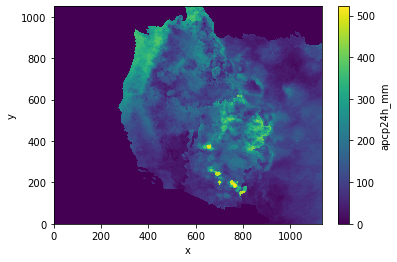

In [8]:
for threshold in [0.01]:
    yes_count = xr.where(urma24 > threshold, 1, 0).sum(dim='valid')
    yes_count.plot()

In [9]:
os.makedirs(urma_dir + 'agg/', exist_ok=True)
urma24.to_netcdf(urma_dir + 'agg/urma_agg.new.nc')

In [ ]:
time = urma24.valid.values
gap_ends = np.where(((time[1:] - time[:-1]).astype(np.float32)/3.6e12).astype(np.int) > 6)[0]

for ts, te in zip(time[gap_ends], time[gap_ends+1]):
    missings = pd.date_range(ts, te, freq='6H')[1:-1]
    
    for missing in missings:
        print(missing)
        
    print()